In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

# 转换为独热编码
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

# 设置显示样式的参数
# http://seaborn.pydata.org/generated/seaborn.set.html
sns.set(style='white', context='notebook', palette='deep')

In [70]:
# import warnings
# warnings.filterwarnings('ignore')

In [71]:
# 加载数据
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

(42000,)
(42000, 784)


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

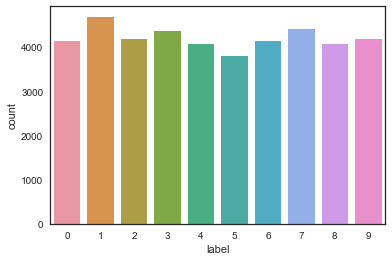

In [72]:
# 'label'
Y_train = train["label"]
print(Y_train.shape)

# 删除 'label' 列
X_train = train.drop(labels = ["label"],axis = 1) 
print(X_train.shape)

# 释放一些空间
del train

# 使用条形图显示每个分类数据集合中的观测值
# https://seaborn.pydata.org/generated/seaborn.countplot.html?highlight=countplot
g = sns.countplot(Y_train)

# 对训练集中的元素计数
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html
Y_train.value_counts()

In [73]:
# 检查数据
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [74]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [75]:
# 对数据进行归一化，到[0, 1]范围内，减小光照的影响，并可加速CNN收敛速度
X_train = X_train / 255.0
test = test / 255.0

In [76]:
# Reshape三维图像(height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [77]:
# 将标签编码为一个独热向量 (例如: 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

In [78]:
# 设置随机种子
random_seed = 2

# 分割出训练集和验证集
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

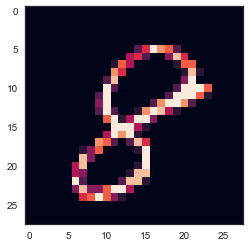

In [79]:
# 一些例子
g = plt.imshow(X_train[0][:,:,0])

In [80]:
# 设置CNN模型
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
# model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

# 输出模型各层的参数状况
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
batch_normalization_20 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 28, 32)        25632     
_________________________________________________________________
batch_normalization_21 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_22 (Batc (None, 14, 14, 64)       

In [81]:
# 用adam优化器和交叉熵损失进行编译
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# 用sgd优化器
# model.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"])

# 定义优化器
# optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# 编译模型
# model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [82]:
# 设置一个学习率衰减
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [83]:
# 训练轮数，暂时设置为1，可以自己尝试调整
epochs = 30
# epochs = 30 时可以99.5%
# 批大小
batch_size = 86

In [84]:
# 增加数据以防止过拟合
datagen = ImageDataGenerator(
        featurewise_center=False,  				# 在数据集上将输入平均值设置为0
        samplewise_center=False,  				# 将每个样本的平均值设置为0
        featurewise_std_normalization=False,    # 将输入除以数据集的std
        samplewise_std_normalization=False,  	# 将每个输入除以它的std
        zca_whitening=False,  					# 使用ZCA白化
        rotation_range=10,  					# 在范围内随机旋转图像（0到180度）
        zoom_range = 0.1, 						# 随机缩放图像
        width_shift_range=0.1,  				# 水平随机移动图像（总宽度的一部分）
        height_shift_range=0.1,  				# 垂直随机移动图像（总高度的一部分）
        horizontal_flip=False,  				# 随机翻转图像
        vertical_flip=False)  					# 随机翻转图像


datagen.fit(X_train)

In [85]:
# 拟合模型
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=[learning_rate_reduction])

Epoch 1/30
 - 378s - loss: 0.3523 - accuracy: 0.8947 - val_loss: 0.6066 - val_accuracy: 0.8069
Epoch 2/30


C:\Users\Administrat\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 385s - loss: 0.1344 - accuracy: 0.9612 - val_loss: 0.0394 - val_accuracy: 0.9876
Epoch 3/30
 - 402s - loss: 0.1081 - accuracy: 0.9682 - val_loss: 0.0518 - val_accuracy: 0.9860
Epoch 4/30
 - 405s - loss: 0.0933 - accuracy: 0.9729 - val_loss: 0.0393 - val_accuracy: 0.9871
Epoch 5/30
 - 372s - loss: 0.0811 - accuracy: 0.9769 - val_loss: 0.0344 - val_accuracy: 0.9876
Epoch 6/30
 - 360s - loss: 0.0743 - accuracy: 0.9791 - val_loss: 0.0371 - val_accuracy: 0.9888
Epoch 7/30
 - 359s - loss: 0.0677 - accuracy: 0.9818 - val_loss: 0.0271 - val_accuracy: 0.9919
Epoch 8/30
 - 368s - loss: 0.0615 - accuracy: 0.9829 - val_loss: 0.0363 - val_accuracy: 0.9907
Epoch 9/30
 - 374s - loss: 0.0613 - accuracy: 0.9837 - val_loss: 0.0285 - val_accuracy: 0.9912
Epoch 10/30
 - 360s - loss: 0.0540 - accuracy: 0.9853 - val_loss: 0.0336 - val_accuracy: 0.9914
Epoch 11/30
 - 360s - loss: 0.0507 - accuracy: 0.9854 - val_loss: 0.0407 - val_accuracy: 0.9888
Epoch 12/30
 - 358s - loss: 0.0533 - accuracy: 0.9854 - val

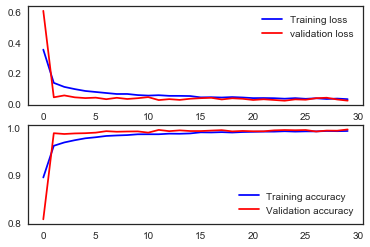

In [86]:
# 绘制训练和验证的损失和精度曲线
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

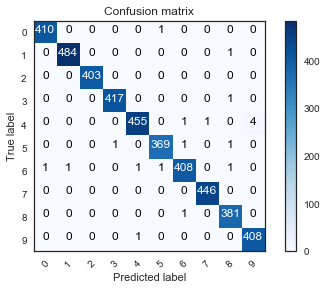

In [87]:
# 看混淆矩阵
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    此函数打印并绘制混淆矩阵
	可以通过设置 “normalize=true” 应用归一化
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# 从验证数据集中预测值
Y_pred = model.predict(X_val)
# 将预测类转换为一个独热向量
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# 将验证观测转换为一个独热向量
Y_true = np.argmax(Y_val,axis = 1) 
# 计算混淆矩阵
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# 绘制混淆矩阵
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

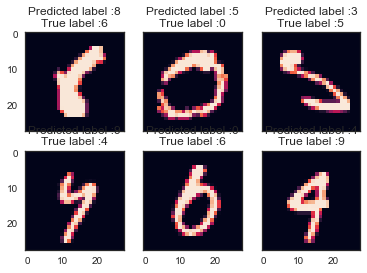

In [88]:
# 显示一些错误结果

# 错误是预测标签和真实标签之间的区别
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """
    此函数显示6个图像及其预测和实际标签
    """
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# 错误预测数的概率
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# 误差集中真值的预测概率
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# 预测标签概率与真实标签概率之差
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# 对预测标签概率与真实标签概率之差的列表进行排序
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6错误
most_important_errors = sorted_dela_errors[-6:]

# 展示Top 6错误
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [89]:
# 预测结果
results = model.predict(test)

# 选择最大概率的整数
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")

In [90]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

# 转换成CSV格式，不保留索引
submission.to_csv("cnn_mnist_datagen.csv",index=False)